In [1]:
#Import libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
import os
import random
import time
import pandas as pd
from tensorflow.keras.models import load_model


# IG Explanation

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
Image 1: C:\Users\Anne\OneDrive - National University of Ireland, Galway\Documents\Data Analytics\PROJECT\Capstone2025_Anne\kaggle\working\merged_images\0\c4965489b34a4954bbafc5d150a10544_1-143_aug963.jpg
  Actual:    Malignant
  Predicted: Malignant (0.4943)


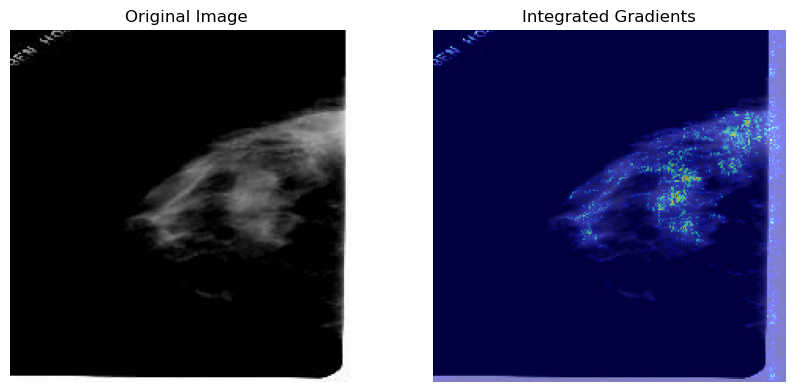

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step
Image 2: C:\Users\Anne\OneDrive - National University of Ireland, Galway\Documents\Data Analytics\PROJECT\Capstone2025_Anne\kaggle\working\merged_images\0\c4965489b34a4954bbafc5d150a10544_1-143_aug963.jpg
  Actual:    Benign
  Predicted: Benign (0.9988)


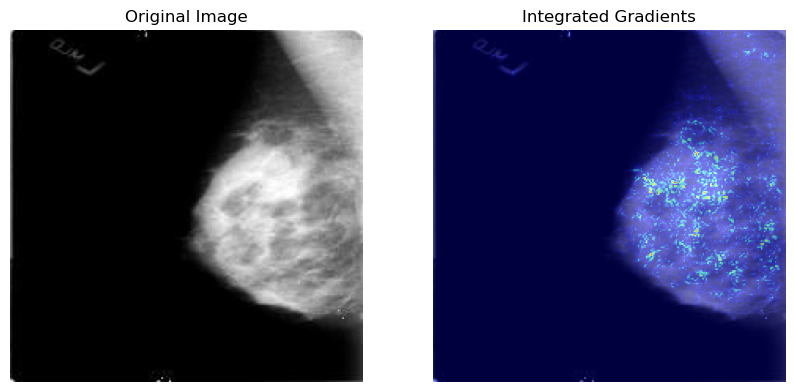

In [ ]:

# ========== CONFIG ==========
model_path = "trained_model/ResNet50.keras"
data_dir = r"C:\Users\Anne\OneDrive - National University of Ireland, Galway\Documents\Data Analytics\PROJECT\Capstone2025_Anne\cbis_ddsm_dataset\merged_data"
class_names = ["Benign", "Malignant"]
img_size = 224

# ===== LOAD MODEL =====
model = tf.keras.models.load_model(model_path)

# ===== LOAD RAW IMAGES =====
def load_images_from_folder(folder, max_images=5):
    image_paths = []
    for root, _, files in os.walk(folder):
        for fname in files:
            if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(root, fname))
    selected_paths = random.sample(image_paths, min(max_images, len(image_paths)))
    images = []
    for path in selected_paths:
        img = image.load_img(path, target_size=(img_size, img_size))
        img_array = image.img_to_array(img)
        images.append(img_array)
    return np.array(images).astype(np.float32), selected_paths

X, paths = load_images_from_folder(data_dir, max_images=2)

# ===== Integrated Gradients Function =====
def integrated_gradients(inputs, model, target_class_idx, baseline=None, steps=50):
    if baseline is None:
        baseline = np.zeros_like(inputs).astype(np.float32)
    
    # Scale inputs and compute gradients
    scaled_inputs = [baseline + (float(i)/steps)*(inputs - baseline) for i in range(0, steps+1)]
    grads = []
    
    for scaled_input in scaled_inputs:
        scaled_input = tf.convert_to_tensor(scaled_input[None, ...])  # Add batch dim
        with tf.GradientTape() as tape:
            tape.watch(scaled_input)
            preds = model(preprocess_input(scaled_input))
            pred = preds[:, 0]  # Assuming output shape (batch, 1)
            loss = pred if target_class_idx == 0 else (1 - pred)
        grad = tape.gradient(loss, scaled_input)[0].numpy()
        grads.append(grad)
    
    avg_grads = np.average(grads[:-1], axis=0)  # average gradients except last point
    integrated_grads = (inputs - baseline) * avg_grads  # element-wise product
    return integrated_grads

# ===== Visualize Integrated Gradients =====
def plot_integrated_grads(img, ig, alpha=0.5):
    ig = np.sum(np.abs(ig), axis=-1)  # Aggregate across channels
    ig = ig / (ig.max() + 1e-8)  # Normalize
    
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.axis('off')
    plt.imshow(img.astype(np.uint8))
    
    plt.subplot(1, 2, 2)
    plt.title("Integrated Gradients")
    plt.axis('off')
    plt.imshow(img.astype(np.uint8))
    plt.imshow(ig, cmap='jet', alpha=alpha)
    
    plt.show()

# ===== Run and Plot IG for samples =====
for i, img in enumerate(X):
    # Get true class from folder name
    class_folder = os.path.basename(os.path.dirname(paths[i]))
    true_label = "Malignant" if class_folder == "1" else "Benign"
    
    # Predict
    img_input = preprocess_input(np.expand_dims(img.copy(), axis=0))
    pred_prob = model.predict(img_input)[0][0]
    pred_label = "Malignant" if pred_prob < 0.5 else "Benign"
    
    # Compute IG for predicted class index
    target_idx = 0 if pred_label == "Benign" else 1
    
    # Integrated gradients
    ig = integrated_gradients(img, model, target_class_idx=target_idx, steps=50)
    
    print(f"Image {i+1}: {paths[1]}")
    print(f"  Actual:    {true_label}")
    print(f"  Predicted: {pred_label} ({pred_prob:.4f})")
    
    plot_integrated_grads(img, ig)


# Calculate Fidelity Score

In [ ]:

# === Configuration ===
data_dir = r"C:\Users\Anne\OneDrive - National University of Ireland, Galway\Documents\Data Analytics\PROJECT\Capstone2025_Anne\cbis_ddsm_dataset\merged_data"
img_size = (224, 224)

# === Integrated Gradients function ===
@tf.function
def integrated_gradients(inputs, target_class_idx, baseline=None, steps=50):
    if baseline is None:
        baseline = tf.zeros(shape=inputs.shape)
    # Generate scaled inputs
    alphas = tf.linspace(0.0, 1.0, steps + 1)
    alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
    delta = inputs - baseline
    interpolated_inputs = baseline + alphas_x * delta  # shape: (steps+1, H, W, C)

    with tf.GradientTape() as tape:
        tape.watch(interpolated_inputs)
        preds = model(interpolated_inputs)
        target = preds[:, target_class_idx]

    grads = tape.gradient(target, interpolated_inputs)
    avg_grads = tf.reduce_mean(grads[:-1] + grads[1:], axis=0) / 2.0
    integrated_grads = delta * avg_grads
    return integrated_grads

# === Fidelity Score Helper ===
def calculate_fidelity_ig(img_array, attributions, model, prob_original):
    heatmap = np.mean(np.abs(attributions), axis=-1)
    mask = heatmap > np.percentile(heatmap, 80)
    mask = mask.astype(np.float32)

    masked_img = img_array.copy()
    masked_img[:, :, 0] *= (1 - mask)
    masked_img[:, :, 1] *= (1 - mask)
    masked_img[:, :, 2] *= (1 - mask)

    input_masked = preprocess_input(masked_img.copy())
    input_masked = np.expand_dims(input_masked, axis=0)
    prob_masked = model.predict(input_masked, verbose=0)[0][0]
    return prob_original - prob_masked

# === Get all image paths ===
image_paths = [
    os.path.join(root, f)
    for root, _, files in os.walk(data_dir)
    for f in files
    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
]

# === Randomly select 50 ===
sample_paths = random.sample(image_paths, min(50, len(image_paths)))

fidelity_scores = []

for img_path in sample_paths:
    # Load and preprocess image
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    input_array = preprocess_input(img_array.copy())
    input_array = np.expand_dims(input_array, axis=0)

    # Original probability (change index if malignant = 1)
    prob_original = model.predict(input_array, verbose=0)[0][0]
    target_class = 0  # Adjust based on your class index

    # Compute Integrated Gradients (remove batch dim for interpolation)
    attributions = integrated_gradients(
        tf.convert_to_tensor(input_array[0:1], dtype=tf.float32),
        target_class_idx=target_class
    )
    attributions = attributions.numpy()[0]

    # Fidelity score
    score = calculate_fidelity_ig(img_array, attributions, model, prob_original)
    fidelity_scores.append(score)

# === Average fidelity score ===
avg_fidelity = np.mean(fidelity_scores)
print(f"📊 Average Integrated Gradients Fidelity Score over {len(sample_paths)} samples: {avg_fidelity:.4f}")



📊 Average Integrated Gradients Fidelity Score over 50 samples: 0.1610


# Code to Evaluate Execution Time

✅ Integrated Gradients took 20.423 seconds
Image 1: 0d875fddcc60408a9ecb6587e9262f12_1-211_aug3340.jpg
  Actual:    Malignant
  Predicted: Benign (0.0000)


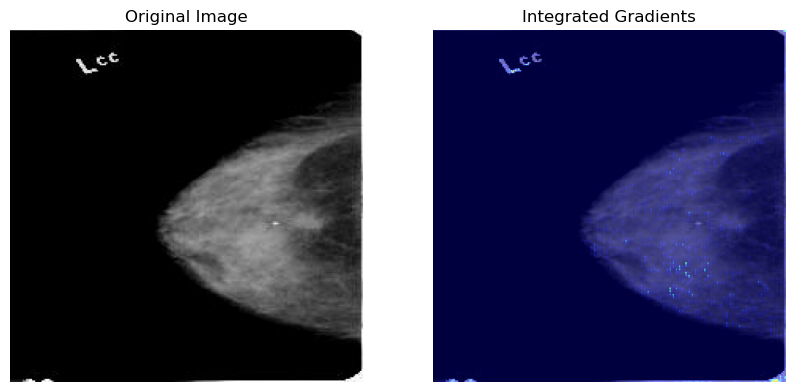

✅ Integrated Gradients took 20.479 seconds
Image 2: d894b24df2834b8d9746f9ff40d47d1f_1-232_aug3945.jpg
  Actual:    Benign
  Predicted: Benign (0.0000)


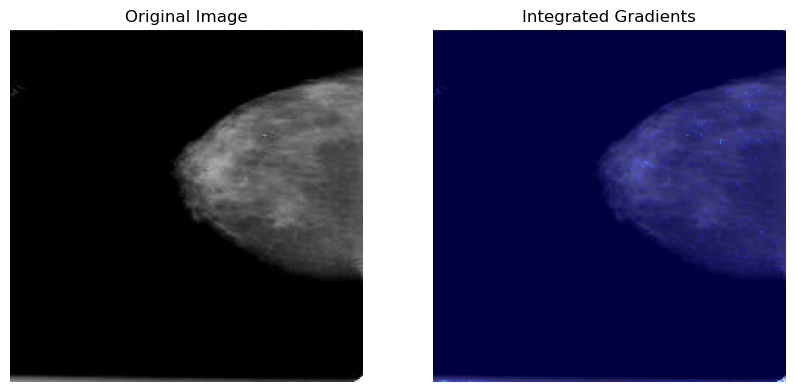

In [ ]:
# ========== CONFIG ==========
model_path = "trained_model/MobileNet.keras"
data_dir = r"C:\Users\Anne\OneDrive - National University of Ireland, Galway\Documents\Data Analytics\PROJECT\Capstone2025_Anne\cbis_ddsm_dataset\merged_data"
class_names = ["Benign", "Malignant"]
img_size = 224

# ===== LOAD MODEL =====
model = tf.keras.models.load_model(model_path)

# ===== LOAD RAW IMAGES =====
def load_images_from_folder(folder, max_images=5):
    image_paths = []
    for root, _, files in os.walk(folder):
        for fname in files:
            if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(root, fname))
    selected_paths = random.sample(image_paths, min(max_images, len(image_paths)))
    images = []
    for path in selected_paths:
        img = image.load_img(path, target_size=(img_size, img_size))
        img_array = image.img_to_array(img)
        images.append(img_array)
    return np.array(images).astype(np.float32), selected_paths

X, paths = load_images_from_folder(data_dir, max_images=2)

# ===== Integrated Gradients Function =====
def integrated_gradients(inputs, model, target_class_idx, baseline=None, steps=50):
    if baseline is None:
        baseline = np.zeros_like(inputs).astype(np.float32)
    
    scaled_inputs = [baseline + (float(i)/steps)*(inputs - baseline) for i in range(0, steps+1)]
    grads = []
    
    for scaled_input in scaled_inputs:
        scaled_input = tf.convert_to_tensor(scaled_input[None, ...])
        with tf.GradientTape() as tape:
            tape.watch(scaled_input)
            preds = model(preprocess_input(scaled_input))
            if target_class_idx == 1:
                loss = preds[:, 0]       # Probability of malignant
            else:
                loss = 1 - preds[:, 0]   # Probability of benign
        grad = tape.gradient(loss, scaled_input)[0].numpy()
        grads.append(grad)
    
    avg_grads = np.average(grads[:-1], axis=0)
    integrated_grads = (inputs - baseline) * avg_grads
    return integrated_grads

# ===== Normalize attributions =====
def normalize_attributions(attributions):
    min_val, max_val = attributions.min(), attributions.max()
    if max_val > min_val:
        return (attributions - min_val) / (max_val - min_val)
    else:
        return np.zeros_like(attributions)

# ===== Visualize Integrated Gradients =====
def plot_integrated_grads(img, ig, alpha=0.5):
    ig = np.sum(np.abs(ig), axis=-1)
    ig = normalize_attributions(ig)
    
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.axis('off')
    plt.imshow(img.astype(np.uint8))
    
    plt.subplot(1, 2, 2)
    plt.title("Integrated Gradients")
    plt.axis('off')
    plt.imshow(img.astype(np.uint8))
    plt.imshow(ig, cmap='jet', alpha=alpha)
    
    plt.show()

# ===== Run and Plot IG for samples =====
for i, img in enumerate(X):
    class_folder = os.path.basename(os.path.dirname(paths[i]))
    true_label = "Malignant" if class_folder == "1" else "Benign"
    
    img_input = preprocess_input(np.expand_dims(img.copy(), axis=0))
    pred_prob = model.predict(img_input, verbose=0)[0][0]
    pred_label = "Malignant" if pred_prob >= 0.5 else "Benign"
    target_idx = 1 if pred_label == "Malignant" else 0
    
    # ===== TIME START =====
    start_time = time.time()
    
    ig = integrated_gradients(img, model, target_class_idx=target_idx, steps=50)
    
    # ===== TIME END =====
    end_time = time.time()
    print(f"✅ Integrated Gradients took {end_time - start_time:.3f} seconds")
    
    print(f"Image {i+1}: {os.path.basename(paths[i])}")
    print(f"  Actual:    {true_label}")
    print(f"  Predicted: {pred_label} ({pred_prob:.4f})")
    
    plot_integrated_grads(img, ig)


# Calculate IOU Score

In [2]:
calc_train = pd.read_csv(r'C:/Users/Anne/OneDrive - National University of Ireland, Galway/Documents/Data Analytics/PROJECT/Capstone2025_Anne/cbis_ddsm_dataset/cbis-ddsm-breast-cancer-image-dataset/csv/calc_case_description_train_set.csv')
calc_test = pd.read_csv(r'C:/Users/Anne/OneDrive - National University of Ireland, Galway/Documents/Data Analytics/PROJECT/Capstone2025_Anne/cbis_ddsm_dataset/cbis-ddsm-breast-cancer-image-dataset/csv/calc_case_description_test_set.csv')
mass_train = pd.read_csv(r'C:/Users/Anne/OneDrive - National University of Ireland, Galway/Documents/Data Analytics/PROJECT/Capstone2025_Anne/cbis_ddsm_dataset/cbis-ddsm-breast-cancer-image-dataset/csv/mass_case_description_train_set.csv')
mass_test = pd.read_csv(r'C:/Users/Anne/OneDrive - National University of Ireland, Galway/Documents/Data Analytics/PROJECT/Capstone2025_Anne/cbis_ddsm_dataset/cbis-ddsm-breast-cancer-image-dataset/csv/mass_case_description_test_set.csv')
dicom_df = pd.read_csv(r'C:/Users/Anne/OneDrive - National University of Ireland, Galway/Documents/Data Analytics/PROJECT/Capstone2025_Anne/cbis_ddsm_dataset/cbis-ddsm-breast-cancer-image-dataset/csv/dicom_info.csv')

cropped_images = dicom_df[dicom_df.SeriesDescription=="cropped images"].image_path
full_mammogram = dicom_df[dicom_df.SeriesDescription=="full mammogram images"].image_path
roi_mask = dicom_df[dicom_df.SeriesDescription=="ROI mask images"].image_path

def replace_path(sample, old_path, new_path):
    return sample.replace(old_path, new_path, regex=True)

# Replace the path for cropped_images to the correct directory.
correct_dir = r"C:/Users/Anne/OneDrive - National University of Ireland, Galway/Documents/Data Analytics/PROJECT/Capstone2025_Anne/cbis_ddsm_dataset/cbis-ddsm-breast-cancer-image-dataset/jpeg"
cropped_images = replace_path(cropped_images, "CBIS-DDSM/jpeg", correct_dir)
print('Cropped Images paths:')
print(cropped_images.iloc[0])

# Replace the path for full_mammogram images to the correct directory.
full_mammogram = replace_path(full_mammogram, "CBIS-DDSM/jpeg", correct_dir)
print('\nFull mammo Images paths:')
print(full_mammogram.iloc[0]) 

# Replace the path for roi_mask images to the correct directory.
roi_mask = replace_path(roi_mask, "CBIS-DDSM/jpeg", correct_dir)
print('\nROI Mask Images paths:')
print(roi_mask.iloc[0])


def get_image_file_name(data, new_dict):
    for dicom in data:
        key = dicom.split('/')[11]
        new_dict[key] = dicom
    print(f"the length of dataset : {len(new_dict.keys())}")

cropped_images_dict = dict()
full_mammo_dict = dict()
roi_img_dict = dict()

get_image_file_name(cropped_images, cropped_images_dict)
get_image_file_name(full_mammogram, full_mammo_dict)
get_image_file_name(roi_mask, roi_img_dict)

def fix_image_path(data):
    for indx, image in enumerate(data.values):
        img_name = image[11].split('/')[2]

        if img_name in full_mammo_dict:
            data.iloc[indx, 11] = full_mammo_dict[img_name]
        else:
            data.iloc[indx, 11] = None
        
        img_name = image[12].split('/')[2]
        if img_name in cropped_images_dict:
            data.iloc[indx, 12] = cropped_images_dict[img_name]
        else:
            data.iloc[indx, 12] = None

        img_name = image[13].split('/')[2]
        if img_name in roi_img_dict:
            data.iloc[indx, 13] = roi_img_dict[img_name]

        else:
            data.iloc[indx, 13] = None

fix_image_path(mass_test)

mass_test = mass_test.rename(columns={'left or right breast': 'left_or_right_breast',
                                        'image view': 'image_view',
                                        'abnormality id': 'abnormality_id',
                                        'abnormality type': 'abnormality_type',
                                        'mass shape': 'mass_shape',
                                        'mass margins': 'mass_margins',
                                        'image file path': 'image_file_path',
                                        'cropped image file path': 'cropped_image_file_path',
                                        'ROI mask file path': 'ROI_mask_file_path'})
mass_test.head(5)


Cropped Images paths:
C:/Users/Anne/OneDrive - National University of Ireland, Galway/Documents/Data Analytics/PROJECT/Capstone2025_Anne/cbis_ddsm_dataset/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.129308726812851964007517874181459556304/1-172.jpg

Full mammo Images paths:
C:/Users/Anne/OneDrive - National University of Ireland, Galway/Documents/Data Analytics/PROJECT/Capstone2025_Anne/cbis_ddsm_dataset/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849/1-249.jpg

ROI Mask Images paths:
C:/Users/Anne/OneDrive - National University of Ireland, Galway/Documents/Data Analytics/PROJECT/Capstone2025_Anne/cbis_ddsm_dataset/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.153339052913121382622526066491844156138/2-270.jpg
the length of dataset : 3567
the length of dataset : 2857
the length of dataset : 3247


,patient_id,breast_density,left_or_right_breast,image_view,abnormality_id,abnormality_type,mass_shape,mass_margins,assessment,pathology,subtlety,image_file_path,cropped_image_file_path,ROI_mask_file_path
0,P_00016,4,LEFT,CC,1,mass,IRREGULAR,SPICULATED,5,MALIGNANT,5,C:/Users/Anne/OneDrive - National University o...,C:/Users/Anne/OneDrive - National University o...,C:/Users/Anne/OneDrive - National University o...
1,P_00016,4,LEFT,MLO,1,mass,IRREGULAR,SPICULATED,5,MALIGNANT,5,C:/Users/Anne/OneDrive - National University o...,C:/Users/Anne/OneDrive - National University o...,C:/Users/Anne/OneDrive - National University o...
2,P_00017,2,LEFT,CC,1,mass,ROUND,CIRCUMSCRIBED,4,MALIGNANT,4,C:/Users/Anne/OneDrive - National University o...,C:/Users/Anne/OneDrive - National University o...,C:/Users/Anne/OneDrive - National University o...
3,P_00017,2,LEFT,MLO,1,mass,ROUND,ILL_DEFINED,4,MALIGNANT,4,C:/Users/Anne/OneDrive - National University o...,C:/Users/Anne/OneDrive - National University o...,C:/Users/Anne/OneDrive - National University o...
4,P_00032,3,RIGHT,CC,1,mass,ROUND,OBSCURED,0,BENIGN,2,C:/Users/Anne/OneDrive - National University o...,C:/Users/Anne/OneDrive - National University o...,C:/Users/Anne/OneDrive - National University o...


In [ ]:
# ===== CONFIG =====
IMG_SIZE = 224
model_path = "trained_model/ResNet50.keras"
model = load_model(model_path)

# ===== PREDICT FUNCTION FOR IG =====
def f(images):
    # images: list of images (H, W, 3), float in [0, 255]
    images = np.array([preprocess_input(img.copy()) for img in images])
    return model.predict(images)

# ===== INTEGRATED GRADIENTS FUNCTION =====
def integrated_gradients(img_array, model, class_index, baseline=None, steps=50):
    if baseline is None:
        baseline = np.zeros_like(img_array).astype(np.float32)
    
    # Reshape image for batch processing
    img_array = img_array.reshape(1, IMG_SIZE, IMG_SIZE, 3)
    baseline = baseline.reshape(1, IMG_SIZE, IMG_SIZE, 3)
    
    # Generate interpolated inputs
    scaled_inputs = [baseline + (float(i)/steps)*(img_array - baseline) for i in range(0, steps+1)]
    grads = []
    
    for scaled_input in scaled_inputs:
        scaled_input = tf.convert_to_tensor(scaled_input)
        with tf.GradientTape() as tape:
            tape.watch(scaled_input)
            preds = model(preprocess_input(scaled_input))
            loss = preds[:, class_index]  # Select probability for target class
        grad = tape.gradient(loss, scaled_input)[0].numpy()
        grads.append(grad)
    
    # Compute average gradients and integrated gradients
    avg_grads = np.average(grads[:-1], axis=0)
    integrated_grads = (img_array - baseline) * avg_grads
    return integrated_grads

# ===== NORMALIZE AND THRESHOLD ATTRIBUTIONS =====
def get_ig_mask(img_array, class_index=None, top_frac=0.2):
    # Predict to get top class if not specified
    if class_index is None:
        img_input = preprocess_input(img_array.copy().reshape(1, IMG_SIZE, IMG_SIZE, 3))
        class_index = np.argmax(f(img_input)[0])
    
    # Compute Integrated Gradients
    ig = integrated_gradients(img_array, model, class_index=class_index, steps=50)
    
    # Convert to grayscale by summing absolute values across channels
    ig_map = np.sum(np.abs(ig), axis=-1)  # Shape: (H, W)
    
    # Normalize and threshold to get binary mask
    ig_map = (ig_map - ig_map.min()) / (ig_map.max() - ig_map.min() + 1e-8)
    threshold = np.quantile(ig_map, 1 - top_frac)  # Keep top_frac of pixels
    mask = (ig_map >= threshold).astype(np.uint8)
    
    return mask

# ===== IOU CALCULATION =====
def calc_iou(pred_mask, roi_mask):
    pred_mask = pred_mask.astype(bool)
    roi_mask = roi_mask.astype(bool)
    intersection = np.logical_and(pred_mask, roi_mask).sum()
    union = np.logical_or(pred_mask, roi_mask).sum()
    return intersection / (union + 1e-8)

# ===== PROCESS IMAGES AND CALCULATE IOU =====
ious = []
for idx, row in mass_test.iterrows():
    if len(ious) >= 50:   # stop once we have 50 values
        break
    img_path = row['image_file_path']
    roi_path = row['ROI_mask_file_path']

    # Load and preprocess image
    img_array = cv2.imread(img_path)
    img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE)).astype(np.float32)

    # Load and preprocess ROI mask
    roi_mask = cv2.imread(roi_path, cv2.IMREAD_GRAYSCALE)
    roi_mask = cv2.resize(roi_mask, (IMG_SIZE, IMG_SIZE))
    roi_mask = (roi_mask > 127).astype(np.uint8)

    # Get IG mask
    ig_mask = get_ig_mask(img_array)

    # Calculate IoU
    iou = calc_iou(ig_mask, roi_mask)
    print(f"IoU for image {idx}: {iou}")
    ious.append(iou)

print("Average IoU (Integrated Gradients):", np.mean(ious))

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
IoU for image 0: 0.045639448357926736
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
IoU for image 1: 0.01712701712700017
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
IoU for image 2: 0.0029829969175668857
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 791ms/step
IoU for image 3: 0.003083656619911386
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step
IoU for image 4: 0.023750372652266965
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
IoU for image 5: 0.031966643502400506
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step
IoU for image 6: 0.02909235827435579
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
IoU for image 7: 0.04352567915918746
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step
IoU for image 8: 0.015312717510176679
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
IoU for image 9: 0.004822360003931874
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
IoU for image 10: 0.01199252924406567
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
IoU for image 11: 0.003279666070360485
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
IoU for image 12: 0.011052995164303707
1/

In [5]:
print("Average IoU (Integrated Gradients):", np.mean(ious))

Average IoU (Integrated Gradients): 0.03502428647311917
